<h1>CSE483 Computer Vision Major Task - Phase 2</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import Libraries
- Use "pip install libName" in terminal if any of them is not installed on your machine.

In [230]:
import numpy as np
import cv2
from scipy.io import loadmat
import json
import matplotlib.pyplot as plt
import scipy
import glob
import random
from skimage.feature import hog
from skimage import exposure
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Custom Fns

In [231]:
# Define the HOG parameters
cell_size = (8, 8)
block_size = (16, 16)
orientations = 9

In [232]:
# Fn import pics, labels, true boxes
def getPics(chosen_set):
    images = []
    labels = []
    boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)
    with open('phase1OutputTrain.json') as f:
        selected_boxes = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            if (data[i]['boxes'][j]['label']==10):
                temp.append(0)
            else:
                temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        boxes.append(selected_boxes[i]['selected_boxes'+str(i)])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    return images, labels, boxes

In [233]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15), cmap = "RGB",title=" "):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize, constrained_layout=True)
    n = 0
    if (nb_rows == 1 and nb_cols ==1):
        plt.imshow(images[0],cmap=cmap)
    elif(nb_rows == 1 or nb_cols ==1):
            for i in range(0, nb_cols+nb_rows-1):
                axs[i].axis('off')
                if(cmap=="gray"):
                    axs[i].imshow(images[n],cmap="gray")
                else:
                    axs[i].imshow(images[n])
                n += 1
    else:
        for i in range(0, nb_rows):
            for j in range(0, nb_cols):
                axs[i, j].axis('off')
                if(cmap=="gray"):
                    axs[i][j].imshow(images[n],cmap="gray")
                else:
                    axs[i][j].imshow(images[n])
                n += 1
    plt.suptitle(title)
    plt.show()


In [234]:
train_images_all, train_labels_all, train_boxes_all = getPics("train")

There are  33402  images in train set.


In [235]:
def cropImages(image, boxes):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    cropped = []
    for box in boxes:
        cropped.append(img[box[1]:box[3], box[0]:box[2]])
    return cropped

In [236]:
def getTemplatesPics():
    templates = []
    labels = []
    picsFolder_path = "Matching2/"

    srtd_dir = sorted(glob.glob(picsFolder_path + "/*.jpg"))
    # import colored pictures
    for image_path in srtd_dir:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        template = {'label':int(image_path[10]), 'image':image}
        templates.append(template)
    return templates

In [237]:
def extract_hog_features(image):
    resized_image = cv2.resize(image, (64, 128))
    hog = cv2.HOGDescriptor()
    hog_features = hog.compute(resized_image)
    hog_features = np.array(hog_features).flatten()
    return hog_features

In [238]:
def getTemplatesHOGs():
    templates = getTemplatesPics()
    full_templates = []
    for template in templates:
        template['descriptor'] = extract_hog_features(template['image'])
        full_templates.append(template)
    return full_templates

In [239]:
def calcPicTrue(trueLabels, predictedLabels):
    truePredictions = list((Counter(trueLabels) & Counter(predictedLabels)).elements())
    return len(truePredictions)

In [240]:
def min_squared_difference(img_hog, tmps_hogs):
    img_hog = np.array(img_hog)
    tmps_hogs = np.array(tmps_hogs)
    return np.argmin(np.sum((tmps_hogs - img_hog) ** 2, axis=1))

In [241]:
def predictImage(image, boxes, tmps_data, tmps_labels):
    croppedImages = cropImages(image,boxes)
    predictions = []
    for img in croppedImages:
        img_hog = extract_hog_features(img)
        idx = min_squared_difference(img_hog, tmps_data)
        predictions.append(tmps_labels[idx])
    return predictions

# Algorithm steps on sample random image

#### Prepare Templates for feature matching:

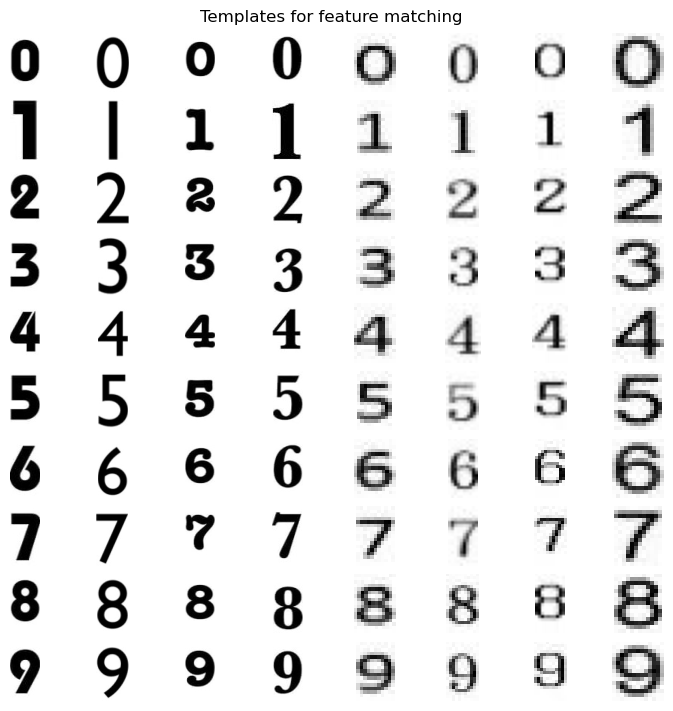

In [242]:
templates = getTemplatesPics()
plot_image_grid([tmp['image'] for tmp in templates],10,int(len(templates)/10),figsize=(7,7),cmap='gray',title="Templates for feature matching")

- Extract templates features using HOG

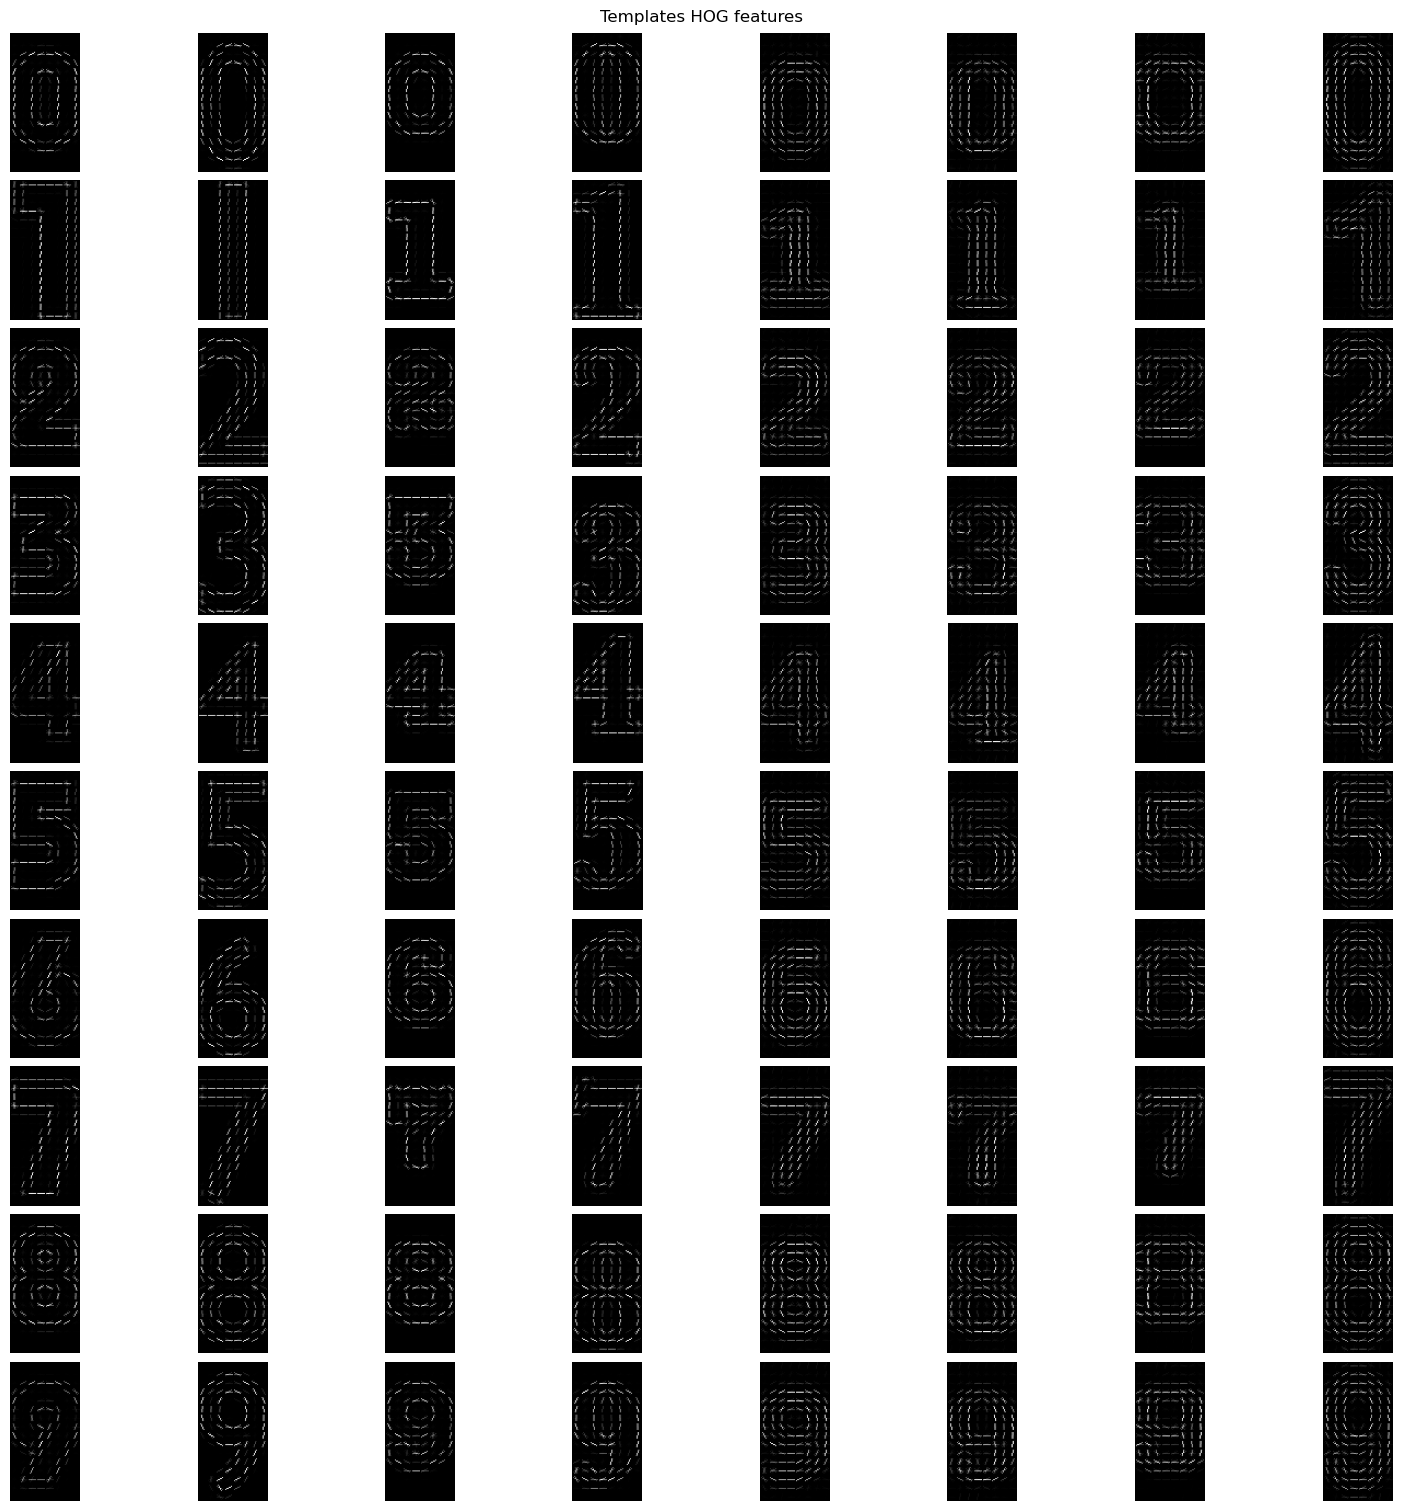

In [243]:
templates_hogs_imgs = []
templates = getTemplatesHOGs()

for tmp in templates:
    hog_features, hog_image = hog(cv2.resize(tmp['image'], (64, 128)), visualize=True)
    templates_hogs_imgs.append(hog_image)

plot_image_grid(templates_hogs_imgs,10,int(len(templates)/10),cmap='gray',title="Templates HOG features")

Picture number:  30267
True Labels: [7. 2. 6.]


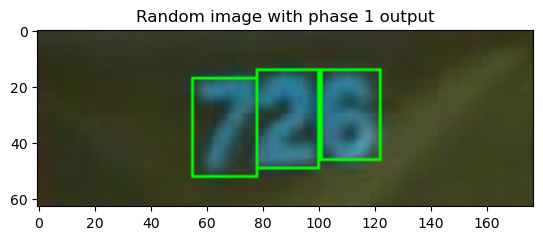

In [289]:
idx = random.randint(0, len(train_images_all)-1)
trialImage = train_images_all[idx].copy()
trialImage = cv2.cvtColor(trialImage,cv2.COLOR_BGR2RGB)
print("Picture number: ", idx+1)
plt.title("Random image with phase 1 output")
print("True Labels:", train_labels_all[idx])
imgBoxes = trialImage.copy()
for i in train_boxes_all[idx]:
    cv2.rectangle(imgBoxes,
                  (i[0],i[1]),
                  (i[2],i[3]),
                  (0,255,0), 1)
plt.imshow(imgBoxes)
plt.show()


- Convert to grayscale & Crop out boxes from phase 1

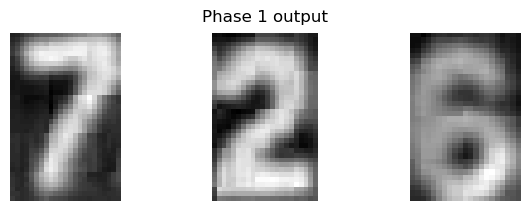

In [290]:
croppedTrial = cropImages(trialImage,train_boxes_all[idx])
plot_image_grid(croppedTrial,1,len(croppedTrial),figsize=(2*len(croppedTrial),2),cmap='gray',title="Phase 1 output")

- Extract HOG features for the cropped images

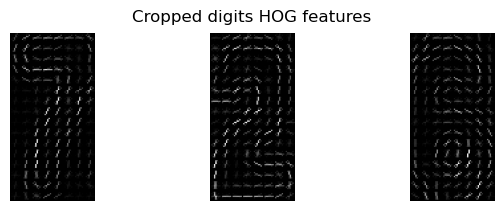

In [291]:
cropped_hogs_imgs = []

for img in croppedTrial:
    hog_features, hog_image = hog(cv2.resize(img, (64, 128)), visualize=True)
    cropped_hogs_imgs.append(hog_image)
plot_image_grid(cropped_hogs_imgs,1,len(cropped_hogs_imgs),figsize=(2*len(cropped_hogs_imgs),2),cmap='gray',title="Cropped digits HOG features")

- Match each cropped digit HOG to the closest template HOG using minimum squared distance

Prediction using feature matching: [7, 2, 6]
True Labels are:  [7. 2. 6.]
Recognition Accuracy for Localized digits: 100.0%


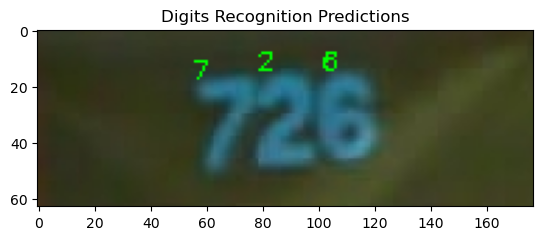

In [292]:
predictions = []
trialImage2 = trialImage.copy()
for img, pos in zip(croppedTrial, train_boxes_all[idx]):
        img_hog = extract_hog_features(img)
        tmp_idx = min_squared_difference(img_hog, [temp['descriptor'] for temp in templates])
        prediction = templates[tmp_idx]['label']
        predictions.append(prediction)
        cv2.putText(trialImage2, str(prediction), (pos[0],pos[1]), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.3, (0, 255, 0), 1)

print("Prediction using feature matching:",predictions)
print("True Labels are: ",train_labels_all[idx])
print("Recognition Accuracy for Localized digits:",str(calcPicTrue(train_labels_all[idx],predictions)*100/len(predictions))+"%")
plt.imshow(trialImage2)
plt.title("Digits Recognition Predictions")
plt.show()

In [281]:
templates = getTemplatesHOGs()
tmps_data = [temp['descriptor'] for temp in templates]
tmps_labels = [temp['label'] for temp in templates]

predicted_labels_sum = 0
true_prediction_sum = 0
true_labels_len = 0
for image, boxes, label in zip(train_images_all, train_boxes_all, train_labels_all):
    true_labels_len+= len(label)
    if(len(boxes)==0):
        continue
    predicted_labels = predictImage(image, boxes, tmps_data, tmps_labels)
    predicted_labels_sum += len(predicted_labels)
    true_prediction_len = calcPicTrue(list(label), predicted_labels)
    true_prediction_sum += true_prediction_len
print("Total Recognition Accuracy for phase 1 output boxes",true_prediction_sum*100 / predicted_labels_sum)
print("Total Recognition Accuracy for all train data boxes",true_prediction_sum*100 / true_labels_len)


Total Recognition Accuracy for phase 1 output boxes 72.65749989190124
Total Recognition Accuracy for all train data boxes 45.875479476364035


------------------------------